# Discovering hidden factors of variation in deep networks

**This is an example of how to implement the autoencoder architecture from [Cheung et al. (2014)](http://arxiv.org/abs/1412.6583) in Lasagne.** This uses the code from the MNIST example bundled with Lasagne, so you will need to have the `mnist.py` file available for importing.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne as nn

Using gpu device 0: GeForce GT 540M


**We'll define the model listed in the first column of Table 1 in the paper.**

This model has an encoder with two ReLU layers. In the paper they both have 500 units but we'll make this configurable so we can speed up the experiment a bit if necessary.

On top of the encoder are two representation layers: one is a 10-way softmax layer which represents the class of the input. This is the observed representation layer. Then there is also a latent representation layer which has two additional linear units (the authors use only two units for easy visualization).

Both representation layers are concatenated and the decoder is stacked on top. This consists of three layers: two hidden ReLU layers with again 500 units, and finally a linear reconstruction layer with 784 outputs.

In [3]:
def build_model(input_dim, output_dim, batch_size,
                num_hidden_units=500):
    l_in = nn.layers.InputLayer((batch_size, input_dim))
    
    # encoder
    l_encoder1 = nn.layers.DenseLayer(l_in, num_units=num_hidden_units)
    l_encoder2 = nn.layers.DenseLayer(l_encoder1, num_units=num_hidden_units)
    
    # learned representation
    l_observed = nn.layers.DenseLayer(l_encoder2, num_units=output_dim,
                                      nonlinearity=T.nnet.softmax)
    
    l_latent = nn.layers.DenseLayer(l_encoder2, num_units=2,
                                    nonlinearity=None) # linear
    
    l_representation = nn.layers.concat([l_observed, l_latent])
    
    # decoder
    l_decoder1 = nn.layers.DenseLayer(l_representation, num_units=num_hidden_units)
    l_decoder2 = nn.layers.DenseLayer(l_decoder1, num_units=num_hidden_units)
    l_decoder_out = nn.layers.DenseLayer(l_decoder2, num_units=input_dim,
                                       nonlinearity=None)
    
    return l_in, l_decoder_out, l_observed, l_latent

Next, **we'll define the cost function**. This consists of three parts: `alpha * U + beta * S + gamma * C` (formula 3 in the paper). `U` is the reconstruction cost, `S` is the supervised cost and `C` is the so-called "XCov" cost which disentangles the observed and latent variables of the encoder.

In [4]:
def cost(x, y, x_recon, y_pred, z, alpha=1.0, beta=10.0, gamma=10.0):
    """
    x, y: the input and the corresponding label
    x_recon: the model reconstruction of the input
    y_pred: the model prediction (observed variables)
    z: the latent variables
    """
    # reconstruction cost: mean squared error
    U = T.mean((x - x_recon)**2)
    
    # supervised cost: categorical cross-entropy
    S = T.mean(T.nnet.categorical_crossentropy(y_pred, y))
    
    # XCov cost: cross-covariance
    y_pred_mean = T.mean(y_pred, axis=0, keepdims=True)
    z_mean = T.mean(z, axis=0, keepdims=True)
    y_pred_centered = y_pred - y_pred_mean # (n, i)
    z_centered = z - z_mean # (n, j)
    
    outer_prod = (y_pred_centered.dimshuffle(0, 1, 'x') *
                  z_centered.dimshuffle(0, 'x', 1)) # (n, i, j)
    C = 0.5 * T.sum(T.sqr(T.mean(outer_prod, axis=0)))
    
    # the total cost is a weighted sum
    return alpha * U + beta * S + gamma * C

Now let's tie everything together in the main training loop.

In [5]:
from mnist import load_data, train
import time

num_epochs = 1000
batch_size = 50

print("Loading data...")
dataset = load_data()

print("Building model and compiling functions...")
l_in, l_decoder_out, l_observed, l_latent = build_model(
    input_dim=dataset['input_dim'],
    output_dim=dataset['output_dim'],
    batch_size=batch_size,
)

x = l_in.input_var
y = T.ivector('y')
x_recon, y_pred, z = nn.layers.get_output([l_decoder_out, l_observed, l_latent])
# Note that we call get_output() once to get all the model outputs.
# This is to guarantee they are consistent and share computations where
# possible. When the network contains nondeterminism (such as dropout
# regularization), guaranteeing this consistency is crucially important.
loss = cost(x, y, x_recon, y_pred, z)
params = nn.layers.get_all_params(l_decoder_out)

# # add some L2 regularization
# params_reg = nn.layers.get_all_params(l_decoder_out, regularizable=True)
# reg = sum(T.sum(p**2) for p in params_reg)
# loss += 0.01 * reg

# The authors mention that they use adadelta, let's do the same
updates = nn.updates.adadelta(loss, params)

# compile iteration functions
batch_index = T.iscalar('batch_index')
batch_slice = slice(batch_index * batch_size,
                    (batch_index + 1) * batch_size)

pred = T.argmax(y_pred, axis=1)
accuracy = T.mean(T.eq(pred, y), dtype=theano.config.floatX)

iter_train = theano.function(
    [batch_index], loss,
    updates=updates,
    givens={
        x: dataset['X_train'][batch_slice],
        y: dataset['y_train'][batch_slice],
    },
)

iter_valid = theano.function(
    [batch_index], [loss, accuracy],
    givens={
        x: dataset['X_valid'][batch_slice],
        y: dataset['y_valid'][batch_slice],
    },
)

iter_test = theano.function(
    [batch_index], [loss, accuracy],
    givens={
        x: dataset['X_test'][batch_slice],
        y: dataset['y_test'][batch_slice],
    },
)

iter_funcs =  dict(
    train=iter_train,
    valid=iter_valid,
    test=iter_test,
)

print("Starting training...")
now = time.time()
try:
    for epoch in train(iter_funcs, dataset):
        print("Epoch {} of {} took {:.3f}s".format(
            epoch['number'], num_epochs, time.time() - now))
        now = time.time()
        print("  training loss:\t\t{:.6f}".format(epoch['train_loss']))
        print("  validation loss:\t\t{:.6f}".format(epoch['valid_loss']))
        print("  validation accuracy:\t\t{:.2f} %".format(
            epoch['valid_accuracy'] * 100))

        if epoch['number'] >= num_epochs:
            break

except KeyboardInterrupt:
    pass

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 1000 took 1.394s
  training loss:		7.257622
  validation loss:		3.729217
  validation accuracy:		90.13 %
Epoch 2 of 1000 took 1.389s
  training loss:		2.167065
  validation loss:		3.725276
  validation accuracy:		90.38 %
Epoch 3 of 1000 took 1.387s
  training loss:		1.122056
  validation loss:		3.947574
  validation accuracy:		91.00 %
Epoch 4 of 1000 took 1.390s
  training loss:		0.637005
  validation loss:		3.713434
  validation accuracy:		91.25 %
Epoch 5 of 1000 took 1.390s
  training loss:		0.360592
  validation loss:		3.372721
  validation accuracy:		92.75 %
Epoch 6 of 1000 took 1.391s
  training loss:		0.226336
  validation loss:		3.856828
  validation accuracy:		92.12 %
Epoch 7 of 1000 took 1.390s
  training loss:		0.143949
  validation loss:		3.272814
  validation accuracy:		93.37 %
Epoch 8 of 1000 took 1.392s
  training loss:		0.103618
  validation loss:		3.773900
  validation accuracy:		9

/home/sander/python_modules/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "
/home/sander/python_modules/lasagne/layers/helper.py:67: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "


This overfits rather badly and does not achieve the 98.35% accuracy reported in the paper at all. Probably there's a detail that's missing. My guess is some form of regularization (e.g. weight decay, dropout, data augmentation), but the paper does not mention anything about that, as far as I can tell. It's also possible that the result listed in Table 2 was obtained with a different model, or that the loss is computed differently (maybe we compute an average where they compute a sum, or something like that).

Now let's create a function that computes the latent representation variables z so we can visualize them on the test set.

In [6]:
z = nn.layers.get_output(l_latent)

compute_z = theano.function(
    [], z,
    givens={
        x: dataset['X_test'],
    },
)

z_vals = compute_z()

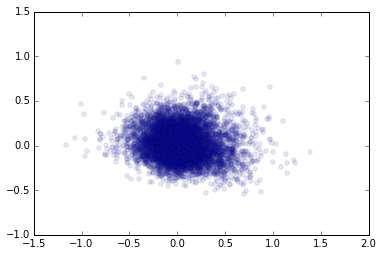

In [7]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(z_vals[:, 0], z_vals[:, 1], alpha=0.1)
plt.show()

This corresponds to figure 4a in the paper. Our latent variables have a smaller magnitude overall, but exhibit a roughly Gaussian distribution just like in the paper.

Now let's generate some reconstructions. Our aim is to reproduce figures 4b and 4c. We'll need to compile a function that allows us to set the desired values for the latent variables `y` and `z`.

Lasagne makes it possible to map any layer in the network to a custom expression by supplying a dictionary to `nn.layers.get_output()`. We'll make use of this to 'clamp' the observed and latent representation variables.

In [8]:
y_clamped = T.ivector('y_clamped')
z_clamped = T.matrix('z_clamped')

x_recon = nn.layers.get_output(l_decoder_out, {
        l_observed: nn.utils.one_hot(y_clamped, m=10),
        l_latent: z_clamped,
    })

reconstruct = theano.function([y_clamped, z_clamped], x_recon)

In [9]:
ys = np.repeat(np.arange(10), 9).astype('int32')
zs = np.tile(np.linspace(-0.5, 0.5, 9), 10).astype(theano.config.floatX)
z1s = np.vstack([zs, np.zeros_like(zs)]).T
z2s = np.vstack([np.zeros_like(zs), zs]).T

In [10]:
reconstructions_z1 = reconstruct(ys, z1s)
reconstructions_z2 = reconstruct(ys, z2s)

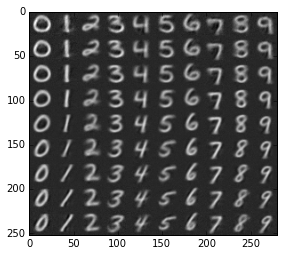

In [11]:
im1 = reconstructions_z1.reshape(10, 9, 28, 28).transpose(1, 2, 0, 3).reshape(9 * 28, 10 * 28)
plt.imshow(im1, cmap=plt.cm.gray)
plt.show()

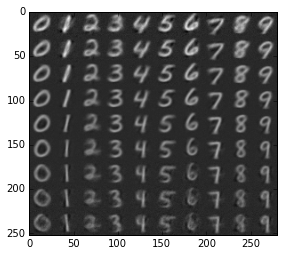

In [12]:
im2 = reconstructions_z2.reshape(10, 9, 28, 28).transpose(1, 2, 0, 3).reshape(9 * 28, 10 * 28)
plt.imshow(im2, cmap=plt.cm.gray)
plt.show()

Despite the lower accuracy, the reconstructions do show some interesting structure as `z1` and `z2` are varied. Pretty cool!